In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
import pennylane as qml

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet-B5 default input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='train', transform=transform)
val_dataset = datasets.ImageFolder(root='val', transform=transform)
test_dataset = datasets.ImageFolder(root='test', transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

In [3]:
# Quantum layer
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_features):
        super().__init__()
        self.n_qubits = n_qubits
        weight_shapes = {"weights": (3, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        self.linear = nn.Linear(n_features, n_qubits)

    def forward(self, x):
        x_reduced = self.linear(x)
        return self.qlayer(x_reduced)

In [5]:
import torch

class CustomEfficientNetB5(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNetB5, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b5')
        self.base_model._fc = nn.Identity()  # Remove the original classification layer

        self.batch_norm = nn.BatchNorm1d(2048)  # EfficientNetB5 has 2048 output features
        self.dense1 = nn.Linear(2048, 1024)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dense2 = nn.Linear(1024, 128)
        self.dropout2 = nn.Dropout(p=0.45)
        self.output_layer = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.base_model(x)
        x = self.batch_norm(x)
        x = torch.relu(self.dense1(x))
        x = self.dropout1(x)
        x = torch.relu(self.dense2(x))
        x = self.dropout2(x)
        x = self.output_layer(x)
        return x

class QuantumEfficientNetB5(nn.Module):
    def __init__(self, num_classes):
        super(QuantumEfficientNetB5, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b5')
        self.base_model._fc = nn.Identity()  # Remove the original classification layer
        
        n_features = 2048  # EfficientNet-B5 output features
        
        self.quantum_layer = QuantumLayer(n_qubits=n_qubits, n_features=n_features)
        
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(n_qubits),
            nn.Linear(n_qubits, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.quantum_layer(x)
        x = self.classifier(x)
        return x

num_classes = len(train_dataset.classes)
# Instantiate the models
classical_model = CustomEfficientNetB5(num_classes)
quantum_model = QuantumEfficientNetB5(num_classes)

# Load the state dictionaries from the .pth files
classical_model.load_state_dict(torch.load('classical_efficientnet_model.pth'))
quantum_model.load_state_dict(torch.load('quantum_efficientnet_model.pth'))

# Set the models to evaluation mode
classical_model.eval()
quantum_model.eval()


Loaded pretrained weights for efficientnet-b5
Loaded pretrained weights for efficientnet-b5


QuantumEfficientNetB5(
  (base_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dSt

In [6]:
import numpy as np

# Function to get predictions from a model
def get_predictions(model, loader):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for data, labels in loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

# Get predictions for classical model
classical_predictions, true_labels = get_predictions(classical_model, test_loader)

# Get predictions for quantum model
quantum_predictions, _ = get_predictions(quantum_model, test_loader)


In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Accuracy
classical_accuracy = accuracy_score(true_labels, classical_predictions)
quantum_accuracy = accuracy_score(true_labels, quantum_predictions)

print(f'Classical Model Accuracy: {classical_accuracy}')
print(f'Quantum Model Accuracy: {quantum_accuracy}')

# Confusion Matrix
classical_cm = confusion_matrix(true_labels, classical_predictions)
quantum_cm = confusion_matrix(true_labels, quantum_predictions)

print('Classical Model Confusion Matrix:')
print(classical_cm)
print('Quantum Model Confusion Matrix:')
print(quantum_cm)

# Classification Report
classical_report = classification_report(true_labels, classical_predictions)
quantum_report = classification_report(true_labels, quantum_predictions)

print('Classical Model Classification Report:')
print(classical_report)
print('Quantum Model Classification Report:')
print(quantum_report)


Classical Model Accuracy: 0.90625
Quantum Model Accuracy: 0.9675
Classical Model Confusion Matrix:
[[200   0   0   0]
 [  1 131  68   0]
 [  0   6 194   0]
 [  0   0   0 200]]
Quantum Model Confusion Matrix:
[[200   0   0   0]
 [  0 189  11   0]
 [  0  14 185   1]
 [  0   0   0 200]]
Classical Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       0.96      0.66      0.78       200
           2       0.74      0.97      0.84       200
           3       1.00      1.00      1.00       200

    accuracy                           0.91       800
   macro avg       0.92      0.91      0.90       800
weighted avg       0.92      0.91      0.90       800

Quantum Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       0.93      0.94      0.94       200
           2       0.94      0.93      0.

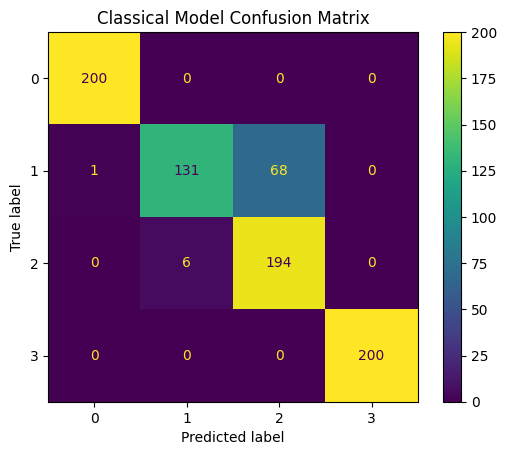

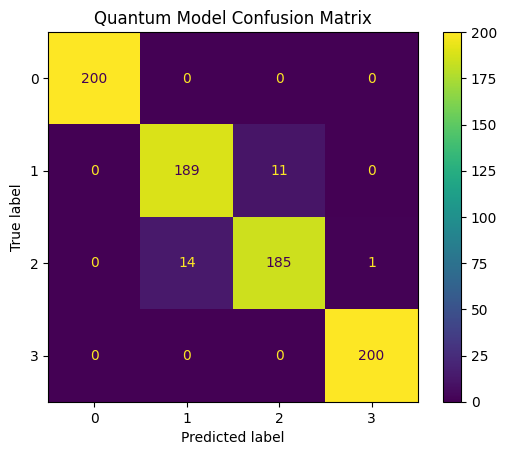

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix for classical model
disp_classical = ConfusionMatrixDisplay(confusion_matrix=classical_cm)
disp_classical.plot()
plt.title('Classical Model Confusion Matrix')
plt.show()

# Plot confusion matrix for quantum model
disp_quantum = ConfusionMatrixDisplay(confusion_matrix=quantum_cm)
disp_quantum.plot()
plt.title('Quantum Model Confusion Matrix')
plt.show()
